# Week 10: Convolutional Neural Networks

<hr style="border:2px solid gray">

# Outline <a id='outline'></a>

1. [Section One: Introduction to convolutional neural networks](#section-1)
1. [Section Two: Convolutional neural networks in PyTorch](#section-2)
1. [Section Three: A convolutional neural network example with Fashion MNIST](#section-3)
1. [Section Four: The CIFAR-10 dataset](#section-4)
1. [Section Five: Exercises](#section-5)

<hr style="border:2px solid gray">

# Section One: Introduction to convolutional neural networks [^](#outline) <a id='section-1'></a>

So far, we have tackled problems we can solve with linear layers and nonlinear activation functions. Let us consider an image classification problem, for example using the MNIST dataset (which is a dataset of 28 by 28 grayscale images). 

<div style="background-color:#C2F5DD">

### Example
    
Consider a binary classification problem such that we have a single output, we flatten our 28 by 28 image input into a 784 length input vector, and we construct a fully connected network with a single hidden layer of 512 neurons. 
    
How many parameters are in this network? Discuss with people near you.    

Your answer here


<div style="background-color:#C2F5DD">

End of example

If we now consider the same network construction for a full HD image that is 1920 by 1080, we find we have over a billion parameters for this network. If we consider a colour image,  Clearly, it will very quickly become unfeasible to train a standard neural network for image classification tasks. Because of how many parameters we have, we are likely to overfit when we train such a network. How can we solve this problem? 

When we look at an image, a given pixel is likely to share structure with other pixels near it in the image. We can use this to inform how we structure our model; we want to somehow use this shared **local** structure to develop a good classifier. 

While our standard neural networks are made of linear layers and activation functions, convolutional neural networks add a new type of layer: convolutional layers. 


## Convolutional layers

You will be familiar with convolutions from previous courses on Fourier transforms, but we will briefly review the fundamental concepts before we discuss how they are applied in machine learning.

<div style="background-color:#FFCCCB">

A convolution between two functions produces a third function that expresses how the shape of one of the functions is modified by the other. The convolution of two functions $f$ and $g$ can be written as 

\begin{equation*}
(f * g)(t) = \int_{-\infty}^\infty f(t - \tau) g(\tau) d\tau,
\end{equation*}
where $\tau$ is a dummy variable introduced for the integration. We can see this as "sliding" the function $f(t - \tau)$ over the function $g(t)$ as we vary $\tau$ in the integration. 

If instead our functions $f$ and $g$ are functions of discrete variables, we can write this expression as a sum instead of an integral:

\begin{equation*}
(f * g)(t) = \sum_{\tau = -\infty}^\infty f(t - \tau) g(\tau)
\end{equation*}

When we apply convolutions in convolutional neural networks, we refer to the function $g(\tau)$ as the input, and the function $f(t - \tau)$ as the **kernel**. The output function $(f * g)(t)$ can be referred to as the **feature map**. Typically, our input is some multidimensional array of data (for example, a colour image with 3 colour channels corresponding to red, green and blue) and the kernel is some multidimensional array of parameters which are learned in the training process. 

Because our inputs are in general finite numerical arrays, we can instead of taking the sum to $-\infty$ and $\infty$ we can instead sum over a finite number of array elements. We also often use convolutions over more than one axis at a time. For example, for a two-dimensional image $I$ as the input and a two-dimensional kernel $K$, we can write the convolution as

\begin{equation*}
S(i, j) = (I * K)(i, j) = \sum_m \sum_n I(m, n) K(i - m, j - n)
\end{equation*}

To put it simply when we apply a kernel of size $N \times M$:

* We take all of the pixels in an $N \times M$ grid around a point in the image and performs a weighted sum, where the kernel contains the weights we use
<br>

* Then, move the kernel one pixel over and take another weighted sum (with the same weights) of the new set of pixels. 
<br>

* You repeat this process for the whole image 

The resulting array is called the feature map and effectively encodes relationships between pixels that are close together, depending on the parameters in the kernel. 

The figure below is an animation showing how we build a feature map from a $4 \times 4$ input and a $2 \times 3$ kernel:

<img src='Week10_plots/conv.gif' align='center' width = 600>

We can also illustrate a convolutional neural network with a schematic of layers with different volumes. Each layer has a height and a width, based on the height and width of an image. We also can have multiple channels in a layer (or our input). In the input this often corresponds to RGB channels in an image, but in our feature maps this can correspond to specific features extracted. We can use multiple kernels in a given layer to produce more channels in our feature map.

<img src='Week10_plots/cnn_depth_schematic.png' width=600>

*Schematic illustrating the action of convolutional layers. Each convolutional layer decreases the height and width but increases the number of channels, and the feature map is converted to an output with a single fully connected linear layer at the end.*

## Features of convolutional layers



Convolutional layers learn from data by changing the parameters kept in the kernel. This results in a few key features for this type of network:

1. Translational invariance
1. Re-use of parameters

We will discuss each of these in turn.



### Translational invariance

If we train a standard neural network on an image dataset, the neurons in individual layers learn to respond to specific pixels in the image. For example, consider an neural network to identify where a dog is in an image. If we just train it with pictures of dogs in the lower right of the image, as soon as we present a data point with the dog in e.g. the upper left, the model will perform poorly.

In contrast, because for a convolutional neural network the weights are all stored in the kernel, you do not learn on specific pixels and instead extract relationships between adjacent pixels. This means you can pick up individual patterns regardless of where they are in the input, meaning your network response has translational invariance. 

For example, say we have a kernel that is good at locating a dog in an image. Because all the weights are in the kernel, if we shift the location of a dog in an image all we do is shift the corresponding output by the same amount. We will be equally good at detecting the dog regardless of where it is in the image. 

### Re-use of parameters

Consider a $m \times n$ linear layer. All $m$ input values are connected to all $n$ output values, resulting in an array of weights you have to learn that is $m \times n$ in size. 

In contrast, for a convolutional network, the weights array we learn in a given layer is just the size of the kernel; e.g. for a kernel of shape $i \times j$, even if we have $m \gt i,\, j$ inputs, we only have to learn $i \times j$ parameters for that kernel. This greatly reduces the number of  weights we have to learn, to get the same sized input/output. We *only* have to learn the parameters in the kernel.



## Controlling the size of CNNs

While up to this point we have just discussed how CNNs are more effective that traditional neural networks for computer vision, we do need to be aware of the size of our CNNs. After we apply a given kernel, depending on the size of the kernel and the size of the input, we can get an output of the same size or smaller than our input. We can also increase the size relative to the input, by using more than one kernel. 

Typically, if there are more specific features we want to try to extract, we will use more kernels. For example, there are two different kernels for extracting vertical and horizontal edges from an image we saw earlier called the [Sobel operators](https://en.wikipedia.org/wiki/Sobel_operator). However, the more kernels we use, the more output neurons we end up with after our convolutional layer. 

If we are using multiple kernels every layer, we can quickly end up with much deeper layers and many more neurons than we started with, but when we come to make our final prediction we need to reduce our size down to what our output needs to be, e.g. a single number of we are predicting a single class or a single regression value. There are three main ways we can do this:

1. Have a linear, fully-connected layer at the end of our network
<br>

1. Increase the **stride**
<br>

1. Use **pooling**

The first of these results in many parameters that need to be trained, exactly what we wanted to avoid! So in general we won't do this. Instead, we make use of stride and pooling.

### Stride

The stride of a convolutional layer refers to how many pixels we move our kernel across our input when we pass through a convolutional layer. If we increase the stride, we move by more pixels between applications of the convolutional kernel; e.g. if we have a stride of N, we will do one convolution, then move our kernel by N pixels before we do another convolution. This is illustrated in the animation below.

<img src='Week10_plots/stride.gif' width=1000>

*Illustration of the effect of setting stride > 1 for a convolution. Whereas on the left we have a stride of 1 and produce an output that is 5 x 5 from the 6 x 6 input, on the right with a stride of 2 we instead produce a 3 x 3 output. We can therefore use stride to reduce the size of the output from our layer. $X_i$ denotes the $i$th input, $w_j$ denotes the $j$th weight in the kernel, and $o_k$ denotes the $k$th output from the convolutional layer.*

However, it is important to note that when using stride we can lose information; for example, we can miss connections between two adjacent pixels if they are not covered by the kernel in a single step. In our example animation, any connection between $X_1$ and $X_2$ will be missed with our stride = 2 kernel. We do therefore need to be careful with when we use stride.

### Pooling

So far we have just discussed how we can change the process of the convolution. However, this is not the only thing we can do; instead, we can do pooling. You can think of this a bit like reducing the resolution of our image. 

When pooling, we separate our input into small blocks or 'pools', e.g. 2 x 2 volumes of inputs, and applying some mathematical operation to each pool to obtain a single value for each pool. The output size is then reduced by a factor of N, where N is the number of inputs in each pool. For our 2 x 2 case, we therefore reduce the size by a factor of 4.

The most common choice of operation to apply is taking the maximum, i.e. the output for a given pool is the maximum value of all of the inputs in the pool. This has the advantage that if your kernel has found a very localised feature, you will not dilute the response to that feature. A schematic illustrating max pooling can be seen in the figure below.

<img src='Week10_plots/pool_schematic_final.svg' width=1000>

*Schematic illustrating max pooling, using a 2 x 2 filter and a stride of 2. The resulting output is the maximum value in each pool.*

Another option is so-called 'average' pooling, where you take the mean of the inputs in the pool. This is illustrated in the schematic below. However, in general max pooling gives better results.

<img src='Week10_plots/avg_pool_schematic.svg' width=1000>

*Schematic illustrating average pooling, using a 2 x 2 filter and a stride of 2. The resulting output is the mean value in each pool.*

### Padding

When we apply a convolutional layer, we may also want to keep the output size the same as the input size. However, if our kernel is bigger than 1 x 1, this won't happen unless we use **padding**. 

Padding refers to adding extra values into the input around the edges, so we can place our kernel on our input enough times to produce an output of the same size. This is also important to make sure we get the most use out of inputs in the corners and on edges. When we use padding, we can use different so-called **padding schemes**. This determines what values we put in as the extra values, e.g. just filling in 0s, or doing so-called "mirror" padding where we reflect the edge values out. There are other types of padding that you can read about in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad). The schematic below illustrates zero and mirror padding.

All the principles underpinning convolutional neural networks are also involved in many of the most modern advances in machine learning, including graph neural networks, autoencoders and transformers. 

## Summary

In this section, we have introduced the concepts of convolutional neural networks, including:

* Convolutional layers
* Advantages of convolutional layers vs linear layers
* How to control the size of a convolutional neural network

In the next section, we will discuss how we can implement convolutional neural networks in Pytorch, including discussion of the `torchvision` package.

<!-- Padding schematic -->

<hr style="border:2px solid gray">

# Section Two: Convolutional neural networks in PyTorch [^](#outline) <a id='section-2'></a>

When we define convolutional neural networks in PyTorch, we need to define convolutional layers, which are implemented in `torch.nn`, along with a number of other useful layers for convolutional networks. PyTorch also includes a subpackage called `torchvision` which includes a number of common datasets, architectures, and transformations for computer vision tasks. 

## The `torchvision` package



This package is particularly useful for the set of datasets, pre-trained networks, and image transformations that it contains. We saw this briefly when we introduced the FashionMNIST dataset last week. 

If we load a dataset from `torchvision`, we can pass a set of transformations that should be applied to each input when it is loaded. This allows to automatically convert data to a Tensor, normalize, or even make other image transformations like resizing images, adding random noise, cropping, rotating, and more. You can find a list of transformations in the [documentation](https://pytorch.org/vision/stable/transforms.html#v1-api-reference). 

`torchvision` also includes many common datasets used for testing computer vision algorithms, such as the FashionMNIST dataset we have seen already, or the CIFAR10 dataset that we will see later in this notebook. Just like in scikit-learn these are easy to import and load, and several of the datasets are already split into train and test sets. 

Because many computer vision datasets are large, they are not included by default in a package install and can instead be downloaded when you import the dataset, by passing the keyword `download = True`. 

Finally, `torchvision` includes some famous pretrained networks that you can use and fine-tune to a particular problem, although this is beyond the scope of this course. You can read more about these networks [here](https://pytorch.org/vision/stable/models.html).



## CNNs in PyTorch

CNNs are well supported in PyTorch and we can add relevant layers to our existing `nn.Sequential` blocks, including convolutional, padding, and pooling layers. We will look at each of these in turn. 

There are a number of convolutional layer options in PyTorch, but the most common we will use is [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d). This applies a 2D convolution over an input with multiple channels. You can specify the number of input channels, the number of output channels, and the size of the kernel, as well as the stride of the convolution and if you want any padding of the input. There are other options too, that you can see in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d). 

We will illustrate a convolutional layer with a couple specific kernels, and apply it to an image to illustrate the effect of having multiple kernels. 

(-0.5, 299.5, 137.5, -0.5)

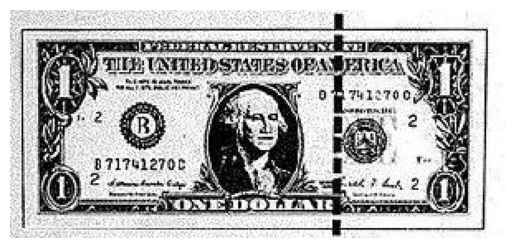

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and visualise the image
img = Image.open('dollar_image.jpg')

plt.imshow(img)
plt.axis('off')

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

print(transform(img))

# conv_layer = nn.Conv2d()

tensor([[[0.4902, 0.6549, 0.4118,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.1765, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4196, 1.0000, 0.8353,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 0.3255, 1.0000,  ..., 0.9451, 0.9608, 0.9843],
         [0.5373, 0.9059, 0.3333,  ..., 1.0000, 1.0000, 1.0000],
         [0.9059, 0.6000, 0.9529,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.4902, 0.6549, 0.4118,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.1765, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4196, 1.0000, 0.8353,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 0.3255, 1.0000,  ..., 0.9451, 0.9608, 0.9843],
         [0.5373, 0.9059, 0.3333,  ..., 1.0000, 1.0000, 1.0000],
         [0.9059, 0.6000, 0.9529,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.4902, 0.6549, 0.4118,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.1765, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4196, 1.0000, 0.8353,  ..., 1.0000, 1.0000, 1.

Structure: 

 - Intro to torchvision (datasets, transforms)
 - Types of layer (convolutional, pooling, padding)
 - 



<hr style="border:2px solid gray">


# Section Three: A convolutional neural network example with Fashion MNIST [^](#outline) <a id='section-3'></a>

Standard example exercise; FashionMNIST classification (set up single class problem? or let them do multiclass?)

<hr style="border:2px solid gray">

# Section Four: The CIFAR-10 dataset[^](#outline) <a id='section-4'></a>

Introduce CIFAR-10 dataset

<hr style="border:2px solid gray">

# Section Five: Exercises <a id='section-5'></a>

Standard style exercises; load CIFAR-10, visualise, try N different architectures? Try adding pooling, stride, etc